# Предсказание   дохода



Целью данной задачи является построение модели **классификации пользователей**: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

## Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#магическая команда, указывает, что графики нужно строить прямо в ноутбуке: 
%matplotlib inline 

In [ ]:
#!pip install comet_ml

In [ ]:
from comet_ml import Experiment

In [ ]:
#@title CometML set up
project_name = 'predict-income'
workspace = 'ketrint'
api_key = ''

In [ ]:
experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)

## Загрузка данных

In [ ]:
%%capture
!wget https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv
!wget https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv

In [ ]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
training_data.head()

Проверим размерности наших файлов:

In [ ]:
training_data.shape, test_data.shape

**Работаем с целевой переменной**



In [ ]:
target_name = 'income'

In [ ]:
y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

**Оценка сбалансированности выборки**

In [ ]:
y_train.value_counts(normalize=True)

Таким образом, имеем задачу **несбалансированной бинарной классификации**. 

## Общая статистика по числовым данным



In [ ]:
X_train.describe().T

In [ ]:
X_train.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_distr', plt)

Что мы можем увидеть из результатов?
* Числовых переменных в исходных данных только 4;
* Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;

## Предобработка данных

### Проверка на наличие пропусков и типов переменных



In [ ]:
X_train.info()

Типы в наших данных:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [ ]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [ ]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [ ]:
X_train['workclass'].value_counts(True).head(1)

In [ ]:
X_train['education'].value_counts(True).head(1)

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [ ]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

Сделаем то же самое для тестовой выборки:

In [ ]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Кодировка категориальных переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категорильные признаки:

In [ ]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [ ]:
X_train[categorical_features].head()

Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**



In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
X_train_le = X_train.copy()

In [ ]:
X_test_le = X_test.copy()

In [ ]:
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [ ]:
X_train_le.head()

**One Hot Encoding**



In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
onehot_encoder = OneHotEncoder()

In [ ]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names(categorical_features)

In [ ]:
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [ ]:
# соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

# удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [ ]:
X_train_new.head()

## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией.
 

In [ ]:
from sklearn.linear_model import LogisticRegression

Создаем прототип класса модели:

In [ ]:
linear_model = 

## Обучение модели на разных типах закодированных данных

In [ ]:
linear_model_oh.fit(X_train_new, y_train)

In [ ]:
linear_model.fit(X_train_le, y_train)

# Валидация модели на тестовой выборке

In [ ]:
prediction_oh = linear_model_oh.predict(X_test_new)

In [ ]:
np.unique(prediction_oh)

array([0, 1])

In [ ]:
# Сколько 1го класса присутсвует в предсказаниях?

In [ ]:
# Сколько 1го класса присутсвует в y_test?

## Точность предсказания

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc_oh = accuracy_score(y_test, prediction_oh)

In [ ]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [ ]:
print('Accuracy Major Class: ', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy Major Class:  0.763


In [ ]:
# Залогировать accuracy для LE

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5881,333
1,663,1264


In [ ]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=811d139ac16c496ca18bedce9acaff29&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8',
 'assetId': '811d139ac16c496ca18bedce9acaff29',
 'web': 'https://www.comet.ml/api/asset/download?assetId=811d139ac16c496ca18bedce9acaff29&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8'}

## Прогноз вероятности принадлежности к классу

In [ ]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)

In [ ]:
# Как выглядят предсказания?

array([[0.9907915 , 0.00920851],
       [0.3954633 , 0.6045367 ],
       [0.2793576 , 0.7206424 ],
       [0.9758066 , 0.02419338],
       [0.9899469 , 0.01005312]], dtype=float32)

In [ ]:
pred_proba = pred_proba_oh[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=60a2196ca6634687bd348a2da76c5b98&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8',
 'imageId': '60a2196ca6634687bd348a2da76c5b98',
 'web': 'https://www.comet.ml/api/image/download?imageId=60a2196ca6634687bd348a2da76c5b98&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8'}

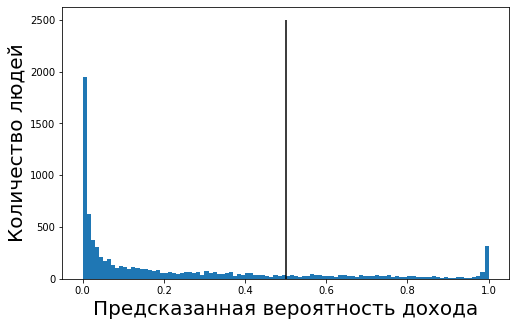

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

##ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba)

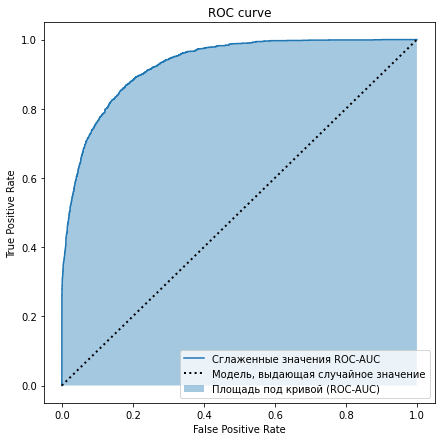

In [ ]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [ ]:
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, pred_proba).round(3)) 

ROC-AUC на тестовой выборке: 0.928


In [ ]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [ ]:
pred_proba_le = linear_model.predict_proba(X_test_new)

In [ ]:
pred_proba = pred_proba_le[:, 1]

In [ ]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)
roc_auc